In [1]:
 '''
Author information:
Joey R. Muffoletto
University of Texas at Austin
Autonomous Systems Group
jrmuff@utexas.edu
'''

'\nAuthor information:\nJoey R. Muffoletto\nUniversity of Texas at Austin\nAutonomous Systems Group\njrmuff@utexas.edu\n'

In [2]:
# import dill
# dill.load_session('realtime_notebook_PURDUE_data_vhub_32_with_queue.db')

In [3]:
import os

import realtime_manager as rm 
import graph_manager as gm
import reworked_graph as rg
import pandas as pd
import numpy as np
import copy
import sys

# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz 2.44.1/bin'

c:\users\joey\appdata\local\programs\python\python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\joey\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\joey\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [4]:
'''
manager configurations

traffic test globals
'''

USE_PURDUE_DATA = True

MAX_ALLOWED_REQUESTS = 5

MIN_TOWERS = 2
NUM_VERTIHUBS = 64
MINUTES_OF_DATA = 1
ADDITIONAL_VERTIHUBS = 0 # used for file path purposes. leave num_vertihubs as the total number of vertihubs (including the additional)

TAU_MAX = 8
TAU = 0

FREQUENCY_MULTIPLIERS = [2]
FREQUENCY_MULTIPLIER = 1

LOW_TRAFFIC_MULTIPLIER = 1
HIGH_TRAFFIC_MULTIPLIER = 3

MIN_LOW_TRAFFIC = 0
MAX_LOW_TRAFFIC = LOW_TRAFFIC_MULTIPLIER * int(NUM_VERTIHUBS * FREQUENCY_MULTIPLIER)

MIN_HIGH_TRAFFIC = MAX_LOW_TRAFFIC
MAX_HIGH_TRAFFIC = HIGH_TRAFFIC_MULTIPLIER * int(NUM_VERTIHUBS * FREQUENCY_MULTIPLIER)

MIN_TTL = 3
MAX_TTL = 7

FLIGHT_SPEED = 60 # m/s



DEFAULT_EMPTY_STATE = rg.State((),(),{"0" : 6})
rm.configure_realtime(tau=TAU, override_default_empty_state=DEFAULT_EMPTY_STATE)

# HIGH_TRAFFIC_FREQUENCY = .1 # use rand.random() = [0.0, 1.0], or, just add this value until = 1 then reset
HIGH_TRAFFIC_TRIGGER = 8
NUM_TIME_STEPS = 20



In [5]:
TRIPS_PATH = ""
VERTIPORTS_PATH = ""
if USE_PURDUE_DATA:
    TRIPS_PATH = 'data/Realtime/OpsLimits/trips_' + str(NUM_VERTIHUBS) + '_minutes-' + str(MINUTES_OF_DATA)
    if ADDITIONAL_VERTIHUBS > 0:
        TRIPS_PATH += '_additional_vhubs_' + str(ADDITIONAL_VERTIHUBS)
    TRIPS_PATH += '.csv'

    VERTIPORTS_PATH = 'data/Realtime/OpsLimits/vertiports_' + str(NUM_VERTIHUBS)
    if ADDITIONAL_VERTIHUBS > 0:
        VERTIPORTS_PATH += '_additional_vhubs_' + str(ADDITIONAL_VERTIHUBS)
    VERTIPORTS_PATH += '.csv'


In [6]:
'''
Input generation functions

low traffic is some random number between min_low_traffic and max_low_traffic, high traffic is the same with high

choose a random tower index everytime we add one

high traffic occurs everytime HIGH_TRAFFIC_FREQUENCY * TIME_STEPS is a whole number

TTL is a random number between MIN_TTL and MAX_TTL

Output format is a dictionary which maps tower index to a list of requests (tuples of preferred port and TTL )

This ouput is created per time step, so then the overall input is a list of these dictionaries, with each list index corresponding to the step of the simulation.

'''
import random
random.seed(10)
def generate_traffic(min_traffic, max_traffic):
    additional_requests_dict = dict()
#     counter = 0
    requests_to_add = random.randint(min_traffic, max_traffic)
    for i in range(requests_to_add):
#         if counter == NUM_VERTIHUBS:
#             counter = 0
#         tower_to_add_to = counter
#         counter+=1
        tower_to_add_to = random.randint(0, NUM_VERTIHUBS-1) # NUM_VERTIHUBS is OOB
        request_to_add = ('no_pref', random.randint(MIN_TTL, MAX_TTL))
#         request_to_add = ('no_pref', 5)
        if tower_to_add_to in additional_requests_dict:
            additional_requests_dict[tower_to_add_to].append(request_to_add)
        else:
            additional_requests_dict[tower_to_add_to] = [request_to_add]
    return additional_requests_dict
            
def generate_low_traffic():
    return generate_traffic(MIN_LOW_TRAFFIC, MAX_LOW_TRAFFIC)
    
def generate_high_traffic():
    return generate_traffic(MIN_HIGH_TRAFFIC, MAX_HIGH_TRAFFIC)

In [7]:
'''
Input Generation
'''
def generate_inputs():
    input = []
    high_traffic_counter = 1
    for time in range(NUM_TIME_STEPS):
        if high_traffic_counter == HIGH_TRAFFIC_TRIGGER:
            high_traffic_counter = 1
            input.append([generate_high_traffic()])
        else:
            high_traffic_counter += 1
            input.append([generate_low_traffic()])

    initial_system = [copy.deepcopy(gm.return_tower(0, 1, [],[6])) for i in range(NUM_VERTIHUBS)]
    return initial_system, input

In [8]:
'''
Input statistics:
'''
def generate_input_statistics(input):
    requests_per_tower = [0 for i in range(NUM_VERTIHUBS)]
    for time_step in range(len(input)):
        for i in range(NUM_VERTIHUBS):
            if i in input[time_step][0]:
                requests_per_tower[i]+=len(input[time_step][0][i])
    for i in range(NUM_VERTIHUBS):
        print("tower " + str(i) + "has " + str(requests_per_tower[i]) + " requests")
    average_input_frequency = sum([i for i in requests_per_tower])/(float(NUM_TIME_STEPS) * float(NUM_VERTIHUBS))
    print("average_input_frequency = " + str(average_input_frequency))
    return average_input_frequency

In [9]:
#purdue data methods
if USE_PURDUE_DATA == True:
    import random
    class Purdue_Data_Output:
        def __init__(self):
            self.num_denied_requests = 0
            self.additional_requests_culled = 0
            self.max_requests = 0
            self.num_expired_requests = 0
            self.expired_requests = [] # tracks the ttl and vertihub id of each expired request when it was popped off of the queue
            self.average_queue_size = [0 for i in range(NUM_VERTIHUBS)]
            
    from math import cos, asin, sqrt, pi

    def ll_distance(lat1, lon1, lat2, lon2):
        p = pi/180
        a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
        return 12742 * asin(sqrt(a)) #2*R*asin...   
        
    # make a list of lists of dictionaries which map tower indicies to requests
    def vertiport_statistics(vertiports_data, _file=sys.stdout):
        '''
        vertiport statistics
        this data is bogus as of 2/18 -> this is because we are not accounting for how the vertiports now can be mapped to multiple vertihubs if we are using additional vhubs
        '''
        vertiports_per_vertihub = [0 for i in range(NUM_VERTIHUBS)]
        for index, vertiport in vertiports_data.iterrows():
#             print((int(vertiport['vertihub'])))
            vertiports_per_vertihub[int(vertiport['vertihub_0'])] += 1
        assert(sum(vertiports_per_vertihub) == vertiports_data.shape[0])
        vertiports_per_vertihub
    
    def trip_statistics(trip_data, vertiports_data, _file=sys.stdout):
        '''
        trip statistics
        '''
        arrivals_per_vertihub = [[] for i in range(NUM_VERTIHUBS)]
        flight_popularity = dict()
        # get the trip arrival time per vertihub
        for index, trip in trip_data.iterrows():
            #calculate time of arrival (begin at trip.time), calculated between vertiports
            origin_port = vertiports_data.iloc[trip['OriginVertiport']]
            destination_port = vertiports_data.iloc[trip['DestinationVertiport']]
            if((origin_port['vertiport'],destination_port['vertiport']) not in flight_popularity.keys()):
                flight_popularity[(origin_port['vertiport'], destination_port['vertiport'])] = 1
            else:
                flight_popularity[(origin_port['vertiport'], destination_port['vertiport'])] += 1
            #trip distance in kilometers
            dist = ll_distance(origin_port['lat'], origin_port['long'], destination_port['lat'], destination_port['long'])
            travel_time = (dist*1000)/FLIGHT_SPEED # (km * 1000)/(m/s) -> seconds
            arrival_time = trip['Time'] + travel_time #takeoff time + travel_time = arrival time
            #add arrival time to vertihub
            arrivals_per_vertihub[trip['DestinationVertihub']].append(arrival_time)
        
        # for each list of vertihub, calculate the minimum, average, and maximum distance between arrivals
        differences_per_vertihub = []
        # simulated_arrivals
        for arrivals_list in arrivals_per_vertihub:
            sorted_arrivals = sorted(arrivals_list)
            if(len(sorted_arrivals) <= 1):
                continue
            differences = []
            for index in range(len(sorted_arrivals)-1):
                differences.append(sorted_arrivals[index+1] - sorted_arrivals[index])
            # print(sorted_arrivals)
            differences_per_vertihub.append(sorted(differences))
        
        for index, differences in enumerate(differences_per_vertihub):
            print('vertihub ' + str(index) + ' has minimum arrival difference of ' + str(differences[0]), file=_file)
            print('vertihub ' + str(index) + ' has average arrival difference of ' + str(sum(differences)/len(differences)), file=_file)
            print('vertihub ' + str(index) + ' has maximum arrival difference of ' + str(differences[len(differences)-1]), file=_file)
            print('vertihub ' + str(index) + ' has ' + str(len(differences)) + ' trips', file=_file)
            print('', file=_file)
           
        
        formatted_flight_popularity = [(flight_popularity[key], key) for key in flight_popularity.keys()]
        print('Most popular flight path ' + str((sorted(formatted_flight_popularity))[len(formatted_flight_popularity)-1]), file=_file)
        print('Total flight paths ' + str(len(formatted_flight_popularity)), file=_file)
        avg = sum([num for num, thing in formatted_flight_popularity])/len(formatted_flight_popularity)
        print('Mean requests per flight path ' + str(avg), file=_file)

        formatted_vertihub_popularity = [(len(differences_per_vertihub[i]), i) for i in range(len(differences_per_vertihub))]

        print('Sorted vertihub popularity: ' + str(sorted(formatted_vertihub_popularity, reverse=True)), file=_file)
    
    def load_vertiport_data(display_stats=True, _file=sys.stdout):
        
        vertiports_data = pd.read_csv(VERTIPORTS_PATH)

        if display_stats:
            vertiport_statistics(vertiports_data, _file)

        return vertiports_data
    def load_trip_data(vertiports_data, display_stats=True, _file=sys.stdout):

        trip_data = pd.read_csv(TRIPS_PATH)
        # Changed (3/8/22) to allow for trips where origin == destination
#         trip_data.drop(trip_data[trip_data.OriginVertihub == trip_data.DestinationVertihub].index, inplace=True) #drop trips where the origin and destination are the same vertiport, reduced from 4801 trips to 1692 with 10 vertiports
        if display_stats:
            trip_statistics(trip_data, vertiports_data, _file)
        return trip_data
    
    def format_purdue_dataset():
        vertiports_data = load_vertiport_data()
        trip_data = load_trip_data(vertiports_data)
        arrivals_per_vertihub = [[] for i in range(NUM_VERTIHUBS)]
        # get the trip arrival time per vertihub
        latest_arrival_time = -1
        for index, trip in trip_data.iterrows():
            #calculate time of arrival (begin at trip.time), calculated between vertiports
            origin_port = vertiports_data.iloc[trip['OriginVertiport']]
            destination_port = vertiports_data.iloc[trip['DestinationVertiport']]
            #trip distance in kilometers
            dist = ll_distance(origin_port['lat'], origin_port['long'], destination_port['lat'], destination_port['long'])
            travel_time = (dist*1000)/FLIGHT_SPEED # (km * 1000)/(m/s) -> seconds
            arrival_time = trip['Time'] + travel_time #takeoff time + travel_time = arrival time
            if(arrival_time > latest_arrival_time):
                latest_arrival_time = arrival_time
            #add arrival time to vertihub
            # arrivals_per_vertihub[trip['DestinationVertihub']].append((
            #     int(arrival_time), 
            #     int(destination_port['vertihub']), 
            #     int(destination_port['vertiport']
            # )))
            arrivals_per_vertihub[trip['DestinationVertihub']].append((
                int(arrival_time), 
                int(trip['DestinationVertihub']), 
                int(destination_port['vertiport']
            )))
        #build input list
        input = [[dict()] for i in range(int(latest_arrival_time)+1)]
        for arrivals in arrivals_per_vertihub:
            for arrival in arrivals:
                arrival_time, destination_hub, destination_port = arrival
                randomized_TTL = random.randint(MIN_TTL, MAX_TTL)
                to_add = (('' + str(destination_port)), randomized_TTL) # (destination port, time to land)
                if destination_hub not in input[arrival_time][0].keys():
                    input[arrival_time][0][destination_hub] = []
                #TODO: CHANGE THIS EVENTUALLY!!!!!
                if(len(input[arrival_time][0][destination_hub]) < 100): 
                    input[arrival_time][0][destination_hub].append(to_add)
          
        #build vertihub list
        initial_vertihubs = []
        for vertihub_index in range(NUM_VERTIHUBS):
            #TODO: fix this... replace 'no_pref' with vertiport_index and figure out the issue with your legacy code! :)
            port_dict = {'no_pref' : 3}
            # 2/18. you figured out that until you use the actual vertiport index, you can just have one no_pref key (dicts do not allow duplicate keys). before, you were trying to add a ('no_pref' : 3 ) k,v pair for every vertiport. u did not realize that it was just one key value pair that actually went through T_T
            # for vertiport_index, vertiport_row in vertiports_data.iterrows():
            #   
            # port_dict = {'no_pref' : 3 for vertiport_index, vertiport_row in vertiports_data.iterrows() if vertiport_row['vertihub'] == vertihub_index}
            accepted_requests_per_time_step = 1
            request_vector = []
            time_vec = []
            vertihub = gm.return_tower_specific(port_dict, accepted_requests_per_time_step, request_vector, time_vec)
            initial_vertihubs.append(vertihub)
        return initial_vertihubs, input
                          
                
                
                                        
    

In [10]:
'''
data collection functions
'''
def run_realtime_data_collection(initial_system_copy, input_copy, PDOs=None):
    gm.reset_globals()
    global MAX_ALLOWED_REQUESTS
    
    _completed_states_per_tau = [[] for i in range(TAU_MAX)]
    _timing_info_per_tau = [[] for i in range(TAU_MAX)]
    for _tau in range(TAU_MAX):
        rm.configure_realtime(tau=_tau, override_default_empty_state=DEFAULT_EMPTY_STATE)
        traces = None
        timings = None
        if not USE_PURDUE_DATA:
            traces, timings = rm.main_loop(initial_system_copy, copy.deepcopy(input_copy))
        else:
            #NOTE: when using the Purdue data, we will be deleting requests that were denied during runs with higher TAUs.
            # that is why we are no longer making a copy of the input_copy, and instead passing the direct reference to be modified
            #NOTE: with request queueing, the previous comment is deprecated. all requests will be kept, but a queue will be used in the event of overflow
            print("INPUT STATISTICS FOR TAU : " + str(_tau))
            generate_input_statistics(input_copy)
            curr_PDO = PDOs[_tau]
            traces, timings = rm.main_loop(initial_system_copy, copy.deepcopy(input_copy), MAX_ALLOWED_REQUESTS=MAX_ALLOWED_REQUESTS, Purdue_Data_Output=curr_PDO)
#             if _tau == 0:
            input_copy = curr_PDO.additional_requests_culled
#                 MAX_ALLOWED_REQUESTS = 100 #because fuck the next guys
        _completed_states_per_tau[_tau] = copy.deepcopy(traces)
        _timing_info_per_tau[_tau] = copy.deepcopy(timings)
        gm.reset_globals()
    return _completed_states_per_tau, _timing_info_per_tau
    #     print(traces)
        # _completed_states, _timing_info = rm.main_loop(initial_system_copy, input_copy)


In [11]:
'''
data collection pipeline
'''
import time
start_time = time.time()
if USE_PURDUE_DATA:
    FREQUENCY_MULTIPLIERS = [1]
    TAU_MAX = 1 #just run it for the TAU = 0 case.

_completed_states_per_tau_per_freq = {freq : [] for freq in FREQUENCY_MULTIPLIERS}
_timing_info_per_tau_per_freq = {freq : [] for freq in FREQUENCY_MULTIPLIERS}
_actual_frequencies_per_freq = {freq : [] for freq in FREQUENCY_MULTIPLIERS}
NUM_TRIALS = 5
for freq in FREQUENCY_MULTIPLIERS:
    if not USE_PURDUE_DATA:
        # setting the frequency multipliers
        MAX_LOW_TRAFFIC = LOW_TRAFFIC_MULTIPLIER * int(NUM_VERTIHUBS * freq)
    
        MIN_HIGH_TRAFFIC = MAX_LOW_TRAFFIC
        MAX_HIGH_TRAFFIC = HIGH_TRAFFIC_MULTIPLIER * int(NUM_VERTIHUBS * freq)
        for i in range(NUM_TRIALS):
            initial_system, input = generate_inputs()
            input_frequency = generate_input_statistics(input) 
            _completed_states_per_tau, _timing_info_per_tau = run_realtime_data_collection(copy.deepcopy(initial_system), copy.deepcopy(input))
            _completed_states_per_tau_per_freq[freq].append(_completed_states_per_tau)
            _timing_info_per_tau_per_freq[freq].append(_timing_info_per_tau)
            _actual_frequencies_per_freq[freq].append(input_frequency)
    else:
        initial_system, _input = format_purdue_dataset() #Purdue dataset
        # print(_input)
        PDOs = [Purdue_Data_Output() for i in range(TAU_MAX)]
        input_frequency = generate_input_statistics(_input) 
        _completed_states_per_tau, _timing_info_per_tau = run_realtime_data_collection(copy.deepcopy(initial_system), copy.deepcopy(_input), PDOs=PDOs)
        _completed_states_per_tau_per_freq[freq].append(_completed_states_per_tau)
        #NOTE: _timing_info_per_tau_per_freq is per round for each vertihub
        #E.g.: _timing_info_per_tau_per_freq[freq][tau][round_idx][vertihub_idx] = [float A, float B, float C]
        #Float A = time to construct vertihub state space, Float B = request passing heuristic
        #Float C = time to find minimally violating trace (Nok/Tulip function)
        _timing_info_per_tau_per_freq[freq].append(_timing_info_per_tau)
        _actual_frequencies_per_freq[freq].append(input_frequency)
        
        for _tau, pdo in enumerate(PDOs):
            print("DENIED REQUESTS, MAX_REQUESTS, TAU " + str(pdo.num_denied_requests) + ", " + str(pdo.max_requests) + ", " + str(_tau))
end_time = time.time()
print('start time = ' + str(start_time) + ' end time = ' + str(end_time) + ' diff = ' + str(end_time - start_time))

vertihub 0 has minimum arrival difference of 0.0
vertihub 0 has average arrival difference of 1.5301100040546416
vertihub 0 has maximum arrival difference of 381.2650478766027
vertihub 0 has 1321 trips

vertihub 1 has minimum arrival difference of 0.0
vertihub 1 has average arrival difference of 34.70832526113504
vertihub 1 has maximum arrival difference of 228.71303636995736
vertihub 1 has 23 trips

vertihub 2 has minimum arrival difference of 0.0
vertihub 2 has average arrival difference of 4.252501356253867
vertihub 2 has maximum arrival difference of 65.16212436972694
vertihub 2 has 285 trips

vertihub 3 has minimum arrival difference of 0.0
vertihub 3 has average arrival difference of 32.42591989843639
vertihub 3 has maximum arrival difference of 133.20628733040644
vertihub 3 has 33 trips

vertihub 4 has minimum arrival difference of 0.0
vertihub 4 has average arrival difference of 2.3768364986767834
vertihub 4 has maximum arrival difference of 60.0
vertihub 4 has 304 trips

verti

tower 0has 1305 requests
tower 1has 24 requests
tower 2has 286 requests
tower 3has 34 requests
tower 4has 305 requests
tower 5has 45 requests
tower 6has 154 requests
tower 7has 85 requests
tower 8has 241 requests
tower 9has 32 requests
tower 10has 6 requests
tower 11has 810 requests
tower 12has 215 requests
tower 13has 13 requests
tower 14has 258 requests
tower 15has 217 requests
tower 16has 1 requests
tower 17has 7 requests
tower 18has 68 requests
tower 19has 31 requests
tower 20has 486 requests
tower 21has 240 requests
tower 22has 414 requests
tower 23has 46 requests
tower 24has 8 requests
tower 25has 12 requests
tower 26has 257 requests
tower 27has 105 requests
tower 28has 219 requests
tower 29has 13 requests
tower 30has 20 requests
tower 31has 32 requests
tower 32has 358 requests
tower 33has 35 requests
tower 34has 27 requests
tower 35has 11 requests
tower 36has 546 requests
tower 37has 617 requests
tower 38has 43 requests
tower 39has 245 requests
tower 40has 10 requests
tower 41ha

Current time step : 1/2117
additional requests = [{}]
Current time step : 2/2117
additional requests = [{}]
Current time step : 3/2117
additional requests = [{}]
Current time step : 4/2117
additional requests = [{}]
Current time step : 5/2117
additional requests = [{}]
Current time step : 6/2117
additional requests = [{}]
Current time step : 7/2117
additional requests = [{}]
Current time step : 8/2117
additional requests = [{}]
Current time step : 9/2117
additional requests = [{}]
Current time step : 10/2117
additional requests = [{}]
Current time step : 11/2117
additional requests = [{}]
Current time step : 12/2117
additional requests = [{}]
Current time step : 13/2117
additional requests = [{}]
Current time step : 14/2117
additional requests = [{}]
Current time step : 15/2117
additional requests = [{}]
Current time step : 16/2117
additional requests = [{}]
Current time step : 17/2117
additional requests = [{}]
Current time step : 18/2117
additional requests = [{}]
Current time step :

Current time step : 63/2117
additional requests = [{}]
Current time step : 64/2117
additional requests = [{}]
Current time step : 65/2117
additional requests = [{}]
Current time step : 66/2117
additional requests = [{}]
Current time step : 67/2117
additional requests = [{}]
Current time step : 68/2117
additional requests = [{}]
Current time step : 69/2117
additional requests = [{}]
Current time step : 70/2117
additional requests = [{}]
Current time step : 71/2117
additional requests = [{}]
Current time step : 72/2117
additional requests = [{}]
Current time step : 73/2117
additional requests = [{}]
Current time step : 74/2117
additional requests = [{}]
Current time step : 75/2117
additional requests = [{}]
Current time step : 76/2117
additional requests = [{}]
Current time step : 77/2117
additional requests = [{}]
Current time step : 78/2117
additional requests = [{}]
Current time step : 79/2117
additional requests = [{}]
Current time step : 80/2117
additional requests = [{}]
Current ti

Current time step : 132/2117
additional requests = [{}]
Current time step : 133/2117
additional requests = [{0: [('21', 5), ('21', 5), ('21', 4), ('21', 5), ('21', 4)], 12: [('154', 6), ('83', 3), ('83', 5)], 32: [('158', 3)], 36: [('117', 3), ('117', 4)]}]
Current time step : 134/2117
additional requests = [{}]
Current time step : 135/2117
additional requests = [{11: [('97', 7)], 20: [('37', 4), ('37', 3), ('37', 7), ('37', 3), ('37', 4), ('37', 3), ('37', 6)], 37: [('11', 3), ('11', 3), ('11', 3), ('11', 4), ('11', 7), ('11', 4)], 44: [('40', 6), ('40', 7), ('138', 5), ('40', 4), ('138', 5), ('40', 7), ('138', 7)]}]
Current time step : 136/2117
additional requests = [{0: [('21', 5), ('38', 7), ('38', 3), ('21', 6), ('21', 5), ('21', 7), ('38', 3), ('21', 4), ('21', 4), ('38', 6), ('21', 4), ('38', 3), ('21', 4), ('21', 7), ('38', 5), ('38', 4), ('38', 3), ('21', 7), ('38', 5), ('38', 7), ('38', 5), ('38', 3), ('21', 6), ('38', 5), ('38', 5), ('21', 7), ('21', 7), ('21', 6), ('38', 5)

Current time step : 168/2117
additional requests = [{0: [('76', 4), ('21', 5), ('76', 7), ('76', 3), ('76', 7), ('76', 4), ('21', 6), ('76', 7), ('76', 7), ('76', 6), ('21', 3)], 6: [('125', 5), ('75', 5), ('125', 4), ('125', 5), ('75', 7)], 26: [('14', 3), ('14', 7), ('47', 6), ('47', 3)], 36: [('4', 5), ('4', 3), ('4', 3)], 37: [('11', 4), ('11', 7), ('11', 4), ('11', 6), ('11', 5), ('11', 3)]}]
Current time step : 169/2117
additional requests = [{0: [('39', 4), ('39', 6)], 11: [('0', 6), ('0', 4), ('0', 5), ('0', 4), ('0', 3), ('0', 3)], 36: [('4', 4), ('4', 4)], 37: [('147', 6), ('147', 4), ('147', 5)]}]
Current time step : 170/2117
additional requests = [{4: [('66', 7), ('66', 4), ('66', 5), ('66', 5), ('66', 7), ('66', 5), ('66', 6), ('66', 5)], 11: [('135', 7), ('97', 3), ('135', 3), ('97', 4), ('97', 7), ('97', 4), ('97', 3), ('97', 4), ('97', 5), ('135', 4)], 22: [('17', 6), ('17', 7)], 37: [('147', 4), ('147', 6), ('147', 4), ('147', 7)], 48: [('16', 5), ('16', 4), ('16', 3)]

Current time step : 191/2117
additional requests = [{0: [('38', 4), ('38', 7), ('128', 7), ('38', 4), ('128', 4), ('128', 5), ('38', 7), ('128', 7), ('128', 5), ('38', 4), ('38', 7), ('38', 3), ('128', 6), ('128', 7), ('128', 6), ('38', 6), ('38', 5), ('38', 5), ('38', 4), ('128', 5), ('128', 3), ('38', 3), ('38', 3), ('128', 5), ('38', 3), ('128', 7), ('128', 7), ('128', 3), ('38', 4), ('128', 4), ('128', 5), ('128', 5), ('128', 6), ('38', 5), ('38', 3), ('38', 6), ('38', 3), ('128', 7), ('128', 4), ('38', 7), ('38', 3), ('128', 3), ('128', 7), ('128', 6), ('38', 6), ('38', 5), ('128', 7), ('38', 5), ('38', 4), ('128', 7), ('38', 7), ('38', 6), ('38', 7), ('128', 7), ('38', 5), ('128', 7), ('128', 6), ('38', 5), ('128', 3), ('128', 7), ('128', 7), ('128', 3), ('38', 3), ('128', 4)], 12: [('62', 6), ('62', 7), ('62', 5)]}]
Current time step : 192/2117
additional requests = [{}]
Current time step : 193/2117
additional requests = [{0: [('21', 7), ('21', 6), ('21', 5), ('21', 3)], 12: [('

Current time step : 213/2117
additional requests = [{14: [('18', 5), ('18', 7), ('18', 4), ('18', 3)], 18: [('127', 6), ('19', 6)], 38: [('126', 3), ('126', 4)], 39: [('54', 4), ('54', 6), ('54', 4), ('54', 7), ('54', 7), ('119', 5), ('54', 3), ('119', 6)]}]
Current time step : 214/2117
additional requests = [{0: [('76', 3), ('76', 6), ('76', 7)], 14: [('98', 5), ('98', 5), ('98', 4)], 20: [('26', 5), ('26', 5), ('26', 7)], 39: [('54', 6), ('54', 4)]}]
Current time step : 215/2117
additional requests = [{4: [('66', 6), ('66', 7), ('66', 3), ('66', 6)], 11: [('0', 3), ('97', 3), ('0', 6), ('97', 3)], 36: [('4', 7), ('4', 6)], 43: [('157', 6), ('157', 5), ('124', 6), ('157', 4), ('124', 7), ('124', 7), ('124', 7), ('157', 3), ('124', 3), ('124', 3), ('157', 4), ('157', 4), ('157', 6), ('157', 7), ('124', 5), ('157', 3), ('157', 6), ('124', 7), ('157', 7), ('157', 4), ('124', 4), ('124', 6), ('157', 5)]}]
Current time step : 216/2117
additional requests = [{4: [('89', 7), ('89', 5), ('89'

Current time step : 236/2117
additional requests = [{0: [('130', 4), ('128', 4)], 12: [('62', 4), ('154', 6), ('62', 5), ('62', 4), ('62', 4), ('154', 6), ('154', 3), ('154', 4), ('154', 5), ('62', 7)], 22: [('17', 5), ('17', 5), ('17', 6), ('96', 3), ('17', 5), ('96', 5), ('17', 7), ('17', 6)], 32: [('86', 5), ('86', 6), ('86', 4), ('86', 3), ('86', 5)], 36: [('33', 7), ('48', 6), ('33', 4), ('33', 3), ('33', 7), ('33', 4)], 49: [('109', 5), ('109', 7), ('109', 7), ('145', 6)]}]
Current time step : 237/2117
additional requests = [{20: [('102', 4)], 21: [('64', 5), ('64', 4), ('64', 3)], 36: [('93', 6), ('48', 3), ('93', 5), ('93', 6), ('48', 6)], 44: [('138', 6)]}]
Current time step : 238/2117
additional requests = [{0: [('128', 4), ('128', 4), ('21', 5), ('21', 4), ('128', 6), ('21', 4), ('128', 3), ('128', 5)], 11: [('97', 3), ('67', 7), ('97', 7), ('67', 6)], 36: [('4', 4), ('93', 3), ('93', 5), ('93', 3)]}]
Current time step : 239/2117
additional requests = [{0: [('128', 6), ('128

Current time step : 257/2117
additional requests = [{4: [('66', 7), ('66', 3), ('66', 4), ('66', 3), ('66', 5), ('66', 7), ('89', 7), ('66', 7), ('66', 6), ('89', 6)], 11: [('0', 4), ('0', 5)], 12: [('62', 5), ('62', 5), ('62', 5)], 14: [('18', 4), ('18', 7), ('18', 6), ('18', 6)], 20: [('102', 3), ('102', 7), ('102', 4), ('102', 6)], 21: [('156', 4)], 37: [('63', 5), ('114', 6), ('114', 6), ('114', 5), ('63', 4), ('114', 3), ('114', 6), ('114', 3), ('114', 5), ('114', 7), ('63', 4), ('114', 4), ('63', 7), ('114', 7), ('61', 3)], 39: [('115', 4), ('115', 7), ('115', 7)], 48: [('16', 7), ('16', 6)], 49: [('121', 4), ('109', 6), ('45', 7), ('45', 5)], 51: [('23', 6)], 52: [('118', 3), ('118', 7)]}]
Current time step : 258/2117
additional requests = [{9: [('110', 6)], 11: [('144', 3), ('144', 6), ('144', 6), ('144', 3), ('144', 7)], 20: [('78', 3), ('78', 7), ('37', 4)], 24: [('122', 3)], 35: [('133', 6)], 36: [('93', 6), ('93', 6)], 37: [('11', 7)], 39: [('115', 4), ('115', 5), ('115', 7

Current time step : 284/2117
additional requests = [{8: [('73', 5), ('73', 3)], 11: [('32', 6), ('32', 5), ('32', 4), ('32', 6)], 15: [('29', 7), ('29', 6), ('148', 4), ('29', 5), ('29', 6), ('148', 4), ('29', 7), ('29', 4)], 20: [('102', 5), ('102', 6), ('78', 6)], 21: [('156', 6), ('156', 4)], 22: [('56', 6), ('56', 4)], 29: [('85', 6)], 36: [('48', 4), ('48', 5), ('48', 7), ('48', 4), ('48', 5)], 38: [('126', 6)], 48: [('16', 7), ('16', 7)], 49: [('145', 7)], 52: [('1', 6), ('1', 3), ('1', 6)], 56: [('143', 6)]}]
Current time step : 285/2117
additional requests = [{3: [('106', 7)], 4: [('137', 4), ('137', 3)], 7: [('43', 3), ('43', 6), ('43', 3), ('60', 6), ('43', 5), ('60', 6), ('60', 3), ('43', 6)], 11: [('67', 7), ('0', 6), ('67', 6), ('0', 7), ('67', 5), ('0', 6), ('0', 7), ('67', 7), ('0', 3)], 14: [('98', 4)], 18: [('19', 6), ('19', 6), ('19', 7)], 26: [('46', 6)], 31: [('6', 4)], 33: [('59', 7)], 39: [('115', 6), ('115', 3), ('115', 3)], 59: [('123', 3)]}]
Current time step :

Current time step : 305/2117
additional requests = [{11: [('32', 3), ('32', 4), ('32', 7)], 15: [('29', 5)], 22: [('17', 3)], 26: [('14', 6)], 28: [('84', 7), ('84', 5), ('84', 6), ('84', 7)], 37: [('147', 5)], 43: [('157', 7)], 49: [('20', 7)]}]
Current time step : 306/2117
additional requests = [{0: [('38', 7), ('38', 7), ('38', 6), ('38', 6), ('38', 6), ('38', 5), ('38', 4), ('38', 6)], 20: [('78', 5), ('78', 3)], 21: [('64', 3)], 22: [('96', 7)], 37: [('11', 7), ('11', 6), ('11', 7), ('11', 4), ('11', 4), ('11', 7)], 44: [('138', 7), ('138', 7), ('138', 5)], 48: [('103', 7)], 60: [('159', 7), ('159', 4)]}]
Current time step : 307/2117
additional requests = [{0: [('39', 4)], 11: [('97', 4), ('97', 7), ('67', 4)], 22: [('96', 4), ('96', 7), ('96', 3), ('96', 5)], 26: [('141', 6), ('141', 6), ('141', 7), ('141', 4)], 32: [('24', 5)], 37: [('63', 3)], 57: [('142', 4), ('142', 7), ('142', 7)]}]
Current time step : 308/2117
additional requests = [{0: [('39', 4), ('39', 6)], 11: [('97', 6

Current time step : 334/2117
additional requests = [{2: [('152', 4), ('152', 6)], 14: [('98', 5)], 18: [('53', 3)], 19: [('41', 4)], 20: [('102', 4), ('26', 6), ('26', 6)], 22: [('17', 4)], 30: [('81', 6), ('81', 5)], 37: [('147', 5), ('147', 6), ('63', 4)], 43: [('157', 3), ('157', 6), ('157', 6), ('157', 5)]}]
Current time step : 335/2117
additional requests = [{2: [('27', 3), ('27', 6)], 4: [('66', 4)], 32: [('158', 3)], 44: [('138', 6), ('138', 7)], 48: [('103', 7)]}]
Current time step : 336/2117
additional requests = [{12: [('62', 6)], 14: [('18', 7)], 26: [('47', 6)], 28: [('35', 6)], 43: [('124', 7)], 52: [('1', 6), ('1', 5)]}]
Current time step : 337/2117
additional requests = [{7: [('60', 7), ('60', 6)], 11: [('32', 3), ('32', 4), ('32', 5), ('32', 5), ('32', 4)], 20: [('37', 5), ('37', 6)], 28: [('7', 3)], 37: [('11', 7), ('11', 6)], 52: [('1', 4), ('1', 6), ('1', 3)], 53: [('12', 5), ('12', 3), ('12', 5), ('12', 7)]}]
Current time step : 338/2117
additional requests = [{11: 

Current time step : 363/2117
additional requests = [{20: [('102', 3)], 22: [('56', 5), ('56', 7), ('56', 4), ('56', 7), ('56', 5)], 37: [('11', 3)], 44: [('40', 3)]}]
Current time step : 364/2117
additional requests = [{4: [('89', 3)], 12: [('62', 5), ('62', 3)], 26: [('14', 6), ('14', 4)]}]
Current time step : 365/2117
additional requests = [{4: [('66', 6)], 11: [('51', 3)], 19: [('41', 4)], 21: [('156', 7), ('156', 5), ('156', 3), ('156', 5)], 24: [('122', 6)], 37: [('147', 3)], 43: [('157', 6)], 60: [('159', 5)]}]
Current time step : 366/2117
additional requests = [{11: [('32', 4), ('32', 6), ('32', 7), ('32', 5)], 20: [('78', 7), ('78', 6)], 22: [('56', 7), ('56', 5), ('56', 4), ('56', 5)], 23: [('36', 5)], 39: [('119', 3)], 60: [('159', 4)]}]
Current time step : 367/2117
additional requests = [{0: [('39', 5), ('38', 7), ('39', 3), ('38', 5)], 11: [('97', 4), ('67', 7), ('97', 6), ('97', 6), ('97', 4), ('97', 6), ('67', 6), ('97', 3)], 22: [('96', 6), ('96', 6), ('96', 4)], 26: [('

Current time step : 395/2117
additional requests = [{4: [('66', 7), ('66', 3), ('66', 3), ('66', 7), ('66', 6)], 12: [('154', 5)], 15: [('150', 6)], 20: [('102', 4)], 28: [('84', 5)], 48: [('103', 7), ('103', 3), ('103', 5)], 52: [('118', 7)]}]
Current time step : 396/2117
additional requests = [{12: [('62', 4), ('62', 7), ('62', 3), ('62', 3), ('62', 5)], 26: [('47', 7), ('47', 7)], 27: [('42', 6)], 34: [('52', 6)], 36: [('33', 5), ('33', 3)], 43: [('124', 6)], 52: [('1', 7), ('118', 5), ('1', 3)]}]
Current time step : 397/2117
additional requests = [{2: [('88', 7)], 11: [('32', 7), ('32', 4), ('32', 7)], 15: [('112', 7)], 28: [('7', 4), ('7', 5)], 31: [('104', 4), ('104', 5)], 37: [('11', 7), ('11', 3)], 38: [('55', 3)], 48: [('155', 3), ('155', 3)], 52: [('1', 5)], 56: [('65', 7)]}]
Current time step : 398/2117
additional requests = [{13: [('149', 5)], 26: [('14', 4), ('46', 7)], 34: [('113', 4)], 48: [('103', 3)], 49: [('145', 7)], 52: [('118', 7)]}]
Current time step : 399/2117
ad

Current time step : 429/2117
additional requests = [{14: [('18', 5), ('18', 5), ('18', 6)], 34: [('95', 7)]}]
Current time step : 430/2117
additional requests = [{0: [('76', 5), ('21', 4), ('76', 5)], 2: [('27', 6), ('27', 7)], 11: [('135', 7), ('135', 7)], 18: [('19', 3)], 22: [('17', 5)], 25: [('68', 5)], 26: [('141', 7)], 28: [('35', 4)], 32: [('24', 7)], 36: [('4', 3)], 38: [('126', 3), ('126', 4)]}]
Current time step : 431/2117
additional requests = [{9: [('110', 3)], 22: [('96', 5), ('96', 7), ('17', 4)]}]
Current time step : 432/2117
additional requests = [{15: [('29', 6)], 22: [('96', 6)], 32: [('86', 3), ('86', 3), ('158', 3)], 37: [('61', 5), ('61', 6)], 49: [('121', 4)], 52: [('118', 4), ('118', 5), ('118', 4)]}]
Current time step : 433/2117
additional requests = [{6: [('75', 7)], 20: [('78', 5), ('26', 3), ('78', 4)], 22: [('134', 5)], 48: [('155', 6), ('155', 6), ('155', 4), ('155', 6), ('155', 3)], 60: [('9', 5)]}]
Current time step : 434/2117
additional requests = [{11: 

Current time step : 474/2117
additional requests = [{4: [('89', 6), ('89', 3)], 30: [('81', 7)], 34: [('95', 4)]}]
Current time step : 475/2117
additional requests = [{4: [('66', 3), ('137', 6)], 11: [('51', 4)], 12: [('83', 5), ('83', 4)], 22: [('17', 6), ('17', 6)], 26: [('46', 4)], 29: [('94', 5)], 32: [('158', 4)], 49: [('45', 4), ('45', 4)]}]
Current time step : 476/2117
additional requests = [{0: [('38', 4), ('21', 4), ('21', 4), ('21', 5), ('128', 3)], 1: [('120', 3), ('120', 3)], 11: [('32', 7)], 20: [('78', 5), ('78', 4)], 38: [('126', 5)], 48: [('155', 4)], 52: [('1', 7)]}]
Current time step : 477/2117
additional requests = [{0: [('21', 3)], 10: [('100', 3), ('100', 6)], 11: [('135', 7)], 21: [('5', 4)], 27: [('116', 6)], 28: [('35', 6)], 39: [('54', 4), ('54', 5)], 44: [('138', 5)], 49: [('145', 4)]}]
Current time step : 478/2117
additional requests = [{7: [('43', 4)], 11: [('51', 5), ('51', 3), ('144', 3), ('144', 5), ('51', 5), ('144', 5)], 26: [('47', 3), ('47', 6), ('47'

Current time step : 519/2117
additional requests = [{6: [('125', 6), ('125', 7), ('125', 6)], 14: [('99', 3)], 18: [('127', 7)], 21: [('64', 3)], 48: [('16', 4)], 49: [('20', 6), ('20', 3)]}]
Current time step : 520/2117
additional requests = [{8: [('87', 6), ('87', 6), ('87', 5)], 20: [('37', 4)], 32: [('92', 6)], 49: [('121', 3)]}]
Current time step : 521/2117
additional requests = [{0: [('76', 6), ('38', 6)], 2: [('88', 3), ('88', 7)], 11: [('97', 7), ('32', 5), ('144', 5)], 12: [('83', 4), ('83', 4)], 22: [('17', 5)], 26: [('141', 3)], 31: [('6', 7), ('6', 3), ('6', 5)], 43: [('124', 5)], 48: [('155', 6), ('155', 5), ('155', 6)]}]
Current time step : 522/2117
additional requests = [{20: [('78', 5)]}]
Current time step : 523/2117
additional requests = [{0: [('39', 6), ('39', 7), ('39', 7), ('39', 3)], 2: [('27', 6)], 11: [('51', 3)], 15: [('148', 7), ('29', 7)], 25: [('68', 5)], 26: [('47', 7)], 49: [('121', 3), ('121', 3)], 56: [('65', 3)], 60: [('159', 4), ('159', 5), ('159', 4)]}

Current time step : 572/2117
additional requests = [{1: [('30', 4)], 2: [('27', 6)], 7: [('77', 7)], 50: [('79', 3)]}]
Current time step : 573/2117
additional requests = [{14: [('18', 3), ('18', 6)], 37: [('61', 3), ('61', 3)], 50: [('79', 7)]}]
Current time step : 574/2117
additional requests = [{0: [('39', 3)], 3: [('106', 7)], 4: [('137', 7)], 15: [('150', 6)], 44: [('40', 6), ('40', 3)], 48: [('155', 6)], 49: [('20', 7)]}]
Current time step : 575/2117
additional requests = [{0: [('38', 6), ('38', 3), ('38', 7), ('38', 5)], 11: [('97', 6)], 13: [('149', 5), ('149', 5)], 22: [('134', 6), ('134', 4), ('134', 7)], 32: [('24', 7), ('24', 4), ('24', 6), ('24', 6)]}]
Current time step : 576/2117
additional requests = [{8: [('10', 3)], 15: [('150', 6)], 22: [('96', 5)], 32: [('86', 7)]}]
Current time step : 577/2117
additional requests = [{2: [('27', 7)], 4: [('66', 6)], 21: [('156', 7)]}]
Current time step : 578/2117
additional requests = [{11: [('0', 7)], 20: [('78', 4)]}]
Current time s

Current time step : 639/2117
additional requests = [{14: [('98', 6), ('98', 3)], 21: [('156', 4)], 37: [('61', 5)]}]
Current time step : 640/2117
additional requests = [{2: [('27', 4)]}]
Current time step : 641/2117
additional requests = [{43: [('124', 5)], 61: [('49', 7), ('49', 6)]}]
Current time step : 642/2117
additional requests = [{3: [('106', 3)], 11: [('97', 3)], 32: [('92', 7)], 40: [('151', 5)]}]
Current time step : 643/2117
additional requests = [{0: [('38', 3)], 4: [('66', 3)], 60: [('9', 3)]}]
Current time step : 644/2117
additional requests = [{36: [('93', 4)]}]
Current time step : 645/2117
additional requests = [{4: [('137', 7)], 12: [('154', 3), ('154', 4)], 23: [('13', 3)], 36: [('93', 5)], 39: [('115', 4)]}]
Current time step : 646/2117
additional requests = [{14: [('99', 7), ('99', 5)], 23: [('36', 3)], 39: [('119', 5)], 51: [('23', 6)]}]
Current time step : 647/2117
additional requests = [{48: [('16', 6)]}]
Current time step : 648/2117
additional requests = [{11: [(

Current time step : 735/2117
additional requests = [{11: [('144', 5)], 14: [('99', 7)], 22: [('56', 6)], 32: [('108', 4)]}]
Current time step : 737/2117
additional requests = [{2: [('140', 5)], 11: [('135', 3)], 48: [('16', 7)]}]
Current time step : 738/2117
additional requests = [{0: [('38', 6)], 12: [('62', 3), ('62', 3)]}]
Current time step : 739/2117
additional requests = [{15: [('112', 5)], 45: [('44', 3)]}]
Current time step : 741/2117
additional requests = [{57: [('28', 7)]}]
Current time step : 744/2117
additional requests = [{37: [('11', 3)]}]
Current time step : 746/2117
additional requests = [{2: [('88', 7)]}]
Current time step : 748/2117
additional requests = [{1: [('30', 4)], 37: [('114', 4), ('114', 3)]}]
Current time step : 750/2117
additional requests = [{37: [('63', 6)], 43: [('157', 6)]}]
Current time step : 751/2117
additional requests = [{0: [('38', 3)], 48: [('16', 5)]}]
Current time step : 753/2117
additional requests = [{8: [('10', 4), ('10', 4), ('10', 3), ('10'

Current time step : 895/2117
additional requests = [{7: [('77', 7)]}]
Current time step : 898/2117
additional requests = [{0: [('130', 3)], 21: [('5', 4)]}]
Current time step : 900/2117
additional requests = [{43: [('157', 3)]}]
Current time step : 911/2117
additional requests = [{44: [('138', 5)]}]
Current time step : 913/2117
additional requests = [{43: [('157', 5)]}]
Current time step : 919/2117
additional requests = [{36: [('48', 6)]}]
Current time step : 920/2117
additional requests = [{22: [('56', 7)]}]
Current time step : 922/2117
additional requests = [{26: [('141', 7)]}]
Current time step : 927/2117
additional requests = [{43: [('124', 4)]}]
Current time step : 928/2117
additional requests = [{15: [('29', 3)], 31: [('104', 3)]}]
Current time step : 930/2117
additional requests = [{15: [('29', 4)]}]
Current time step : 933/2117
additional requests = [{49: [('20', 3)]}]
Current time step : 935/2117
additional requests = [{2: [('152', 6)]}]
Current time step : 938/2117
additional

Current time step : 1597/2117
additional requests = [{6: [('75', 5), ('31', 7)]}]
Current time step : 1610/2117
additional requests = [{20: [('37', 4)]}]
Current time step : 1657/2117
additional requests = [{6: [('31', 5)]}]
Current time step : 1740/2117
additional requests = [{6: [('125', 3)]}]
Current time step : 1747/2117
additional requests = [{6: [('75', 6)]}]
Current time step : 1898/2117
additional requests = [{43: [('124', 5)]}]
Current time step : 1963/2117
additional requests = [{0: [('76', 7)]}]
Current time step : 1970/2117
additional requests = [{6: [('75', 7)]}]
Current time step : 1976/2117
additional requests = [{32: [('108', 6)]}]
Current time step : 2021/2117
additional requests = [{0: [('76', 4)]}]
Current time step : 2107/2117
additional requests = [{20: [('102', 5)]}]
Current time step : 2116/2117
additional requests = [{43: [('157', 7)]}]
DENIED REQUESTS, MAX_REQUESTS, TAU 0, 0, 0
start time = 1650990336.9907765 end time = 1651010288.6060636 diff = 19951.615287065

In [12]:

NUM_TRIALS = 5
if USE_PURDUE_DATA:
    NUM_TRIALS = 1

In [13]:
'''
data buffer
'''
completed_states_per_tau_per_freq = copy.deepcopy(_completed_states_per_tau_per_freq)
timing_info_per_tau_per_freq = copy.deepcopy(_timing_info_per_tau_per_freq)
actual_frequencies_per_freq = copy.deepcopy(_actual_frequencies_per_freq)


# print (_actual_frequencies_per_freq)
# print (_completed_states_per_tau_per_freq)



In [14]:
# print (sum(timing_info_per_tau_per_freq[1.5][0][0])/len(timing_info_per_tau_per_freq[1.5][0][0]))
# print (len(timing_info_per_tau_per_freq[1.5][0][0]))


In [15]:
from datetime import datetime
global folder_path
# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%m_%d_%H%M%S")
folder_path = ('data/Realtime/OpsLimits/' + str(dt_string)) # make folder with the current date time
os.mkdir(folder_path)
def save_plot(plot, name):
    plot.savefig(folder_path + '/' + name + '.png', dpi=200)

In [16]:
# import dill
# if not USE_PURDUE_DATA:
#     dill.dump_session(folder_path + '/realtime_notebook_store_highest_freq.db')
# else:
#     dill.dump_session(folder_path + '/notebook_dump'+str(NUM_VERTIHUBS)+'.db')

In [17]:
'''
PDO analysis
'''

if USE_PURDUE_DATA:
    def PDO_statistics(f=sys.stdout):
        for PDO in PDOs:
            print('requests expired = ' + str(PDO.num_expired_requests), file=f)
            print('min ttl = ' + str(min(PDO.expired_requests)), file=f)
            print('max ttl = ' + str(max(PDO.expired_requests)), file=f)    
            expiration_times = [req[0] for req in PDO.expired_requests]
            print('avg ttl = ' + str(sum(expiration_times)/len(expiration_times)), file=f)
            print('avg queue sizes per vertihub = ' + str(PDO.average_queue_size), file=f)
            print('avg queue size overall = ' + str(sum(PDO.average_queue_size)/len(PDO.average_queue_size)), file=f)
            print('')

PDO_statistics()      

requests expired = 1777
min ttl = (-41, 0)
max ttl = (-1, 54)
avg ttl = -9.46426561620709
avg queue sizes per vertihub = [9.438149197355996, 0.00047214353163361664, 0.176109537299339, 0.0, 0.24079320113314448, 0.0033050047214353163, 0.17469310670443816, 0.022190745986779982, 0.1964117091595845, 0.0, 0.0, 1.1213408876298394, 0.0764872521246459, 0.0, 0.20396600566572237, 0.08498583569405099, 0.0, 0.0, 0.0, 0.0, 0.37488196411709157, 0.09584513692162418, 0.32152974504249293, 0.00141643059490085, 0.0, 0.0, 0.06043437204910293, 0.018885741265344664, 0.047214353163361665, 0.0, 0.0, 0.0, 0.09773371104815864, 0.0028328611898017, 0.0, 0.0, 0.6312559017941454, 0.9995278564683664, 0.0, 0.0906515580736544, 0.0, 0.0, 0.002360717658168083, 0.33899905571293676, 0.032577903682719546, 0.018885741265344664, 0.0, 0.0, 0.039660056657223795, 0.021718602455146365, 0.0, 0.0, 0.10198300283286119, 0.0, 0.03352219074598678, 0.0, 0.00047214353163361664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
avg queue size overall = 

In [18]:
'''
save metadata for runtime information
'''
with open(folder_path + "/run_information.txt", "w") as f:
    f.write("Run information: \n\n")
    f.write("Date of completion: " + now.strftime("%m/%d/%Y %H:%M:%S") + "\n")
    seconds_to_complete = end_time - start_time
    f.write("Completed in " + str(seconds_to_complete) + " seconds (" + str(seconds_to_complete/60.0)  + " minutes)\n\n") 


    if USE_PURDUE_DATA:
        f.write("Purdue Data Information: \n"
                "--------------------------"
                "\n"
            )


        f.write("Trips file: " + str(TRIPS_PATH) + "\n")
        f.write("Vertiports file: " + str(VERTIPORTS_PATH) + "\n")
        f.write("Minutes of data: " + str(MINUTES_OF_DATA) + "\n")
        f.write("Additional Vertihubs: " + str(ADDITIONAL_VERTIHUBS) + "\n")
        f.write("\n")
        f.write("Trip data statistics " )
        f.write("\n")
        vertiport_data = load_vertiport_data(True, f)
        load_trip_data(vertiport_data, True, f)
        f.write("\n")
        f.write("Request queue statistics " )
        f.write("\n")
        PDO_statistics(f)
        f.write("\n\n")
        f.write("End Purdue Data Information: \n"
                "--------------------------"
                "\n"
        )




In [19]:
'''
percentage of valid states
'''
def get_percent_valid(completed_states):
    percent_valid = [0 for i in range(len(completed_states[0]))]
    percent_valid_per_tau = [copy.copy(percent_valid) for i in range(TAU_MAX)]
    for tau,completed in enumerate(completed_states):
        print(completed)
        print("\n\n\n\n\n\n")
        for index, com in enumerate(completed):
            for state in com:
                if("VALID" in state.labels):
                    percent_valid_per_tau[tau][index] += 1

    for tower_cost in percent_valid_per_tau:
        print(tower_cost)
    return percent_valid_per_tau
    
# actual_percentages = [(i/len(completed_states[0])) for i in percent_valid]
# print(actual_percentages)
'''
mvp_output
'''
def get_mvp_output_per_tower_per_tau(completed_states):
    mvp_output_per_tower_per_tau = [rm.get_mvp_output(completed) for completed in completed_states]
    for tau in mvp_output_per_tower_per_tau:
        for output in tau:
            gm.print_formatted_cost(output[0],format_override=True)
    #     output[3].plot()
    #     gm.print_formatted_trace_path(output[1])
    return mvp_output_per_tower_per_tau

'''
calculating heuristic cost
'''
def get_heuristic_cost_per_tau(completed_states):
    heurstic_cost_per_tau = [copy.copy(percent_valid) for i in range(TAU_MAX)]
    for tau,completed in enumerate(completed_states):
        for index, com in enumerate(completed):
            for state in com:
                for req in state.request_vector:
                    if(req == "wrong_tower"):
                        heurstic_cost_per_tau[tau][index] += 1
    for heuristic_cost in heurstic_cost_per_tau:
        print(heuristic_cost)
    return heuristic_cost_per_tau

In [20]:
'''
graphing imports
'''
import matplotlib.pyplot as plt
import numpy as np


In [21]:
'''
Runtime data collection functions

Core data structure is timing_info_per_tau_per_freq

TODO: figure out what this 0 stands for. I think it is based on the number of trials
Example: timing_info_per_tau_per_freq[freq][tau][0][round_idx][vertihub_idx] = [float A, float B, float C]
    Float A = time to construct vertihub state space, Float B = request passing heuristic
    Float C = time to find minimally violating trace (Nok/Tulip function)
    
'''

def avg_cumulative_per_vertihub_runtime(timing_info):
    # ignore freq and tau
    runtimes = timing_info[1][0][0]
    print(len(runtimes))
    cumulative_per_vertihub_runtime = [[0, 0, 0] for _ in range(NUM_VERTIHUBS)]
    for round_idx in range(len(runtimes)):
        for vertihub_idx in range(len(runtimes[round_idx])):
            cumulative_per_vertihub_runtime[vertihub_idx][0] += runtimes[round_idx][vertihub_idx][0]
            cumulative_per_vertihub_runtime[vertihub_idx][1] += runtimes[round_idx][vertihub_idx][1]            
            cumulative_per_vertihub_runtime[vertihub_idx][2] += runtimes[round_idx][vertihub_idx][2]
    #NOTE: averaging by dividing cumulative value by the number of rounds (len(runtimes)) 
    for vertihub_idx in range(len(runtimes[0])):
        cumulative_per_vertihub_runtime[vertihub_idx] = [runtime/len(runtimes) for runtime in cumulative_per_vertihub_runtime[vertihub_idx]]
    return cumulative_per_vertihub_runtime

def generate_per_vertihub_runtime(timing_info):
    cumulative_per_vertihub_runtime = avg_cumulative_per_vertihub_runtime(timing_info)
    
    labels = [i for i in range(NUM_VERTIHUBS)]
    x = np.arange(len(labels))
    width = .2 # bar width    
    # switch axes of cummulative_per_vertihub_runtime
    formatted_runtimes = np.array(cumulative_per_vertihub_runtime)
    formatted_runtimes = np.swapaxes(formatted_runtimes, 0, 1)
    
    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width, formatted_runtimes[0], width, label='State Space Construction')
    bars2 = ax.bar(x, formatted_runtimes[1], width, label='Request Passing Hueristic')
    bars3 = ax.bar(x + width, formatted_runtimes[2], width, label='MVP Synthesis')
    ax.set_yscale("log")
    ax.set_ylabel('Runtime (Seconds, Log Scale)')
    ax.set_title('Logarithmic average time step runtimes per Vertihub')
    ax.set_xticks(labels)
    ax.legend()
    
    fig.tight_layout()
    
    save_plot(plt, 'runtime_information_per_vertihub')
    plt.show()




def generate_avg_per_vertihub_runtime(timing_info):
    cumulative_per_vertihub_runtime = avg_cumulative_per_vertihub_runtime(timing_info)
    labels = ['16 Vertihubs']
    x = np.arange(len(labels))
    width = .8 # bar width    
    # switch axes of cummulative_per_vertihub_runtime
    formatted_runtimes = np.array(cumulative_per_vertihub_runtime)
    formatted_runtimes = np.swapaxes(formatted_runtimes, 0, 1)
    ss_construction_time = sum(formatted_runtimes[0])/NUM_VERTIHUBS
    req_pass_time = sum(formatted_runtimes[1])/NUM_VERTIHUBS
    mvp_synth_time = sum(formatted_runtimes[2])/NUM_VERTIHUBS

    
    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width, ss_construction_time, width, label='State Space Construction')
    bars2 = ax.bar(x, req_pass_time, width, label='Request Passing Hueristic')
    bars3 = ax.bar(x + width, mvp_synth_time, width, label='MVP Synthesis')
#     ax.set_yscale("log")
    ax.set_ylabel('Runtime (Seconds)')
    ax.set_title('Average Vertihub Runtime per Time Step')
    ax.set_xticklabels(labels)
    ax.legend()
    
    ax.bar_label(bars1, padding=3)
    ax.bar_label(bars2, padding=3)
    ax.bar_label(bars3, padding=3)

    
    fig.tight_layout()
    
    save_plot(plt, 'runtime_information')
    plt.show()

2118


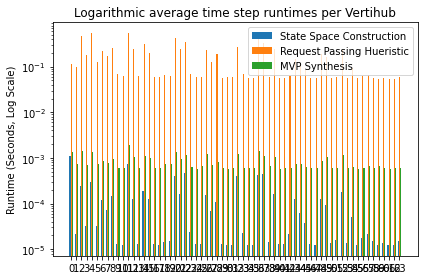

2118


c:\users\joey\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator


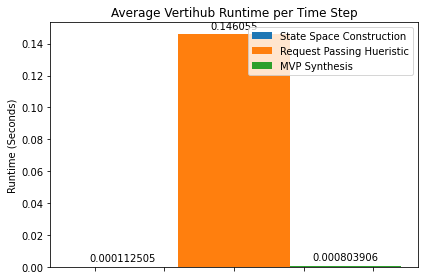

In [22]:
'''
call runtime information functions
'''
generate_per_vertihub_runtime(timing_info_per_tau_per_freq)
generate_avg_per_vertihub_runtime(timing_info_per_tau_per_freq)

In [23]:
'''
table for runtime data

most important data is synthesis per time per timestep. 
Ill just do runtime vs TAU and frequency, one for each trial
'''
# import matplotlib.pyplot as plt

# def generate_runtime_table(timing_info, input_frequencies, trial_num, iteration):
#     row_headers = [''+str(freq) for freq in input_frequencies]
#     column_headers = [''+str(tau) for tau in range(TAU_MAX)]
#     cell_text = []
#     for freq in FREQUENCY_MULTIPLIERS:
#         cell_text.append(timing_info[freq])
#         print(cell_text)
# #         cell_text.append([0 for i in range(TAU_MAX)])
#     the_table = plt.table(cellText=cell_text, rowLabels=row_headers, colLabels=column_headers, loc='center')
#     the_table.scale(1, 1.5)
#     the_table.set_fontsize(25)
    
#     ax = plt.gca()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     plt.box(on=None)
# #     plt.show()
# #     fig = plt.gcf()
#     if USE_PURDUE_DATA:
#         plt.savefig('data/Realtime/OpsLimits/runtime_vs_TAU_and_freq_trial_' + str(trial_num) + '_iteration_' + str(iteration) + '.png',bbox_inches='tight',dpi=216)    
#     else:
#         plt.savefig('data/Realtime/runtime_vs_TAU_and_freq_trial_' + str(trial_num) + '_iteration_' + str(iteration) + '.png',bbox_inches='tight',dpi=216)    
    
#     return plt

# def get_data_per_trial(full_timing_info, full_input_frequencies, trial_index):
#     stub_timing_info = {freq : [0 for i in range(TAU_MAX)] for freq in FREQUENCY_MULTIPLIERS}
#     for freq in full_timing_info:        
#         for TAU in range(len(full_timing_info[freq][trial_index])):
#             timings_without_zeros = [t for t in full_timing_info[freq][trial_index][TAU] if t != 0]
#             stub_timing_info[freq][TAU] += sum(timings_without_zeros)/len(timings_without_zeros)
#     stub_input_frequencies = {freq: 0 for freq in FREQUENCY_MULTIPLIERS}
#     for freq in full_input_frequencies:
#         stub_input_frequencies[freq] = full_input_frequencies[freq][trial_index]
#     return stub_timing_info, stub_input_frequencies
    
    

'\ntable for runtime data\n\nmost important data is synthesis per time per timestep. \nIll just do runtime vs TAU and frequency, one for each trial\n'

In [24]:
# average_timing_info = {freq : [0 for i in range(TAU_MAX)] for freq in FREQUENCY_MULTIPLIERS}
# for trial in range(0, NUM_TRIALS):
#     timing_info, input_freq = get_data_per_trial(timing_info_per_tau_per_freq, actual_frequencies_per_freq, trial)
# #     print(timing_info)
#     for key in timing_info:
#         for index,num in enumerate(timing_info[key]):
#             timing_info[key][index] = round(num,3)
#     generate_runtime_table(timing_info, input_freq, trial, 2)
# #     for key in timing_info:
# #         for index,num in enumerate(timing_info[key]):
# #             average_timing_info[key][index] += num
            
# for key in timing_info:
#     for index,num in enumerate(timing_info[key]):
#         average_timing_info[key][index] = round(num,3)
# fig = generate_runtime_table(average_timing_info, input_freq, trial)
    



In [25]:
'''
data buffer for mvp output
'''
completed_states = completed_states_per_tau_per_freq[1][0]
percent_valid = [0 for i in range(len(completed_states[0]))]
percent_valid_per_tau = [copy.copy(percent_valid) for i in range(TAU_MAX)]
# wrong_towers_per_tau = [copy.copy(percent_valid) for i in range(TAU_MAX)]
wrong_tower_per_time_step = [0 for i in range(len(completed_states[0][0]))]
number_requests_per_TAU = [0 for i in range(len(completed_states[0]))]
# print(completed_states[0][0])
# print(completed_states_per_tau_per_freq[1][0][0][0][0]) freq, something, tau, tower, state
states_per_tau = [0 for i in range(TAU_MAX)]
for tau,completed in enumerate(completed_states): # tau
    for index, com in enumerate(completed): # vertihub
        for time_step, state in enumerate(com):
            if("VALID" in state.labels):
                percent_valid_per_tau[tau][index] += 1
            states_per_tau[tau] += 1
            for req in state.request_vector:
                if req == 'wrong_tower':
                     wrong_tower_per_time_step[time_step] += 1
#                      wrong_towers_per_tau[tau][time_step] += 1
                    
# print(completed_states[0][0])
# sums = [sum(i) for i in wrong_towers_per_tau]
# print(sums)          
other_sums = [sum(i)/states_per_tau[tau] for tau, i in enumerate(percent_valid_per_tau)]
print(other_sums)

    

# for tower_cost in percent_valid_per_tau:
#     print(tower_cost)
# mvp_output_per_tower_per_tau_copy = copy.deepcopy(mvp_output_per_tower_per_tau)
# for tau in mvp_output_per_tower_per_tau_copy:
#     for output in tau:
#         gm.print_formatted_cost(output[0],format_override=True)
# for timings in timing_info:
#     print(sum(timings))
#     print (timings)
    

[0.986182424457035]


No handles with labels found to put in legend.


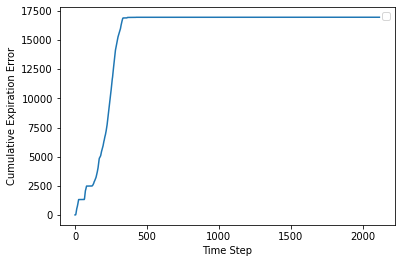

In [26]:

'''
More data processing
plot cost per tau over time
'''
# sum up the negative costs for the tower (get total expiration value)
cost_per_tau_over_time = [[] for i in range(TAU_MAX)]
for index,tau in enumerate(completed_states):
    sum_cost = 0
    for time_step in range(len(completed_states[0][0])):
        for tower in tau:
            for expiration in tower[time_step].time_vector:
                if expiration < 0:
                    sum_cost -= expiration 
#                     sum_cost +=1
        cost_per_tau_over_time[index].append(sum_cost)
cost_per_tau_over_time = cost_per_tau_over_time
# print(cost_per_tau_over_time)
x = [i for i in range(len(completed_states[0][0]))]
plt.plot(x, cost_per_tau_over_time[0])
# for tau_num, tau in enumerate(cost_per_tau_over_time):
#     plt.plot(x, tau, label = "TAU = " + str(tau_num))
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Cumulative Expiration Error')
save_plot(plt, 'cummulative_expiration_error_over_time')
plt.show()

No handles with labels found to put in legend.


[0, 0, 1, 6, 28, 59, 67, 53, 42, 18, 11, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 8, 32, 69, 82, 78, 57, 39, 20, 9, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 6, 7, 6, 4, 2, 7, 10, 9, 6, 10, 9, 12, 13, 14, 11, 12, 10, 6, 6, 7, 12, 13, 9, 12, 8, 5, 5, 4, 4, 4, 5, 7, 10, 9, 7, 5, 4, 6, 7, 9, 10, 12, 16, 12, 14, 13, 10, 13, 13, 11, 8, 10, 10, 7, 4, 4, 4, 5, 9, 16, 19, 20, 11, 11, 12, 9, 10, 14, 16, 19, 25, 21, 17, 18, 17, 18, 9, 6, 7, 8, 12, 15, 14, 12, 14, 5, 4, 4, 7, 13, 23, 25, 27, 22, 10, 9, 9, 9, 9, 9, 14, 15, 15, 12, 14, 19, 19, 16, 17, 14, 18, 16, 11, 8, 8, 7, 10, 12, 16, 20, 27, 24, 12, 15, 13, 8, 9, 14, 13, 15, 17, 12, 14, 7, 11, 10, 9, 12, 15, 15, 15, 15, 11, 13, 15, 12, 12, 11, 19, 19, 22, 22, 25, 22, 14, 12, 13, 7, 6, 9, 12, 10, 6, 5, 7, 5, 6, 4, 5, 6, 7, 9, 9, 8, 8, 7, 8, 11, 10, 12, 12, 14

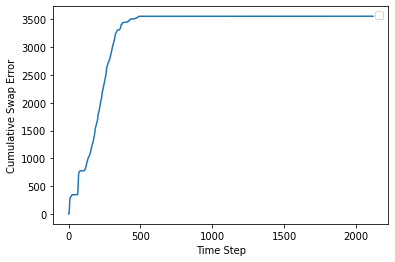

In [27]:

'''
first plot:
cummulative expiration cost vs. time step
label with periods of high traffic and low traffic
do a line per tau
'''
x = [i+1 for i in range(len(completed_states[0][0]))]
cummulative_wrong_tower_error = [0 for i in range(len(wrong_tower_per_time_step))]
for idx, i in enumerate(wrong_tower_per_time_step):
    if idx == 0:
        continue
    cummulative_wrong_tower_error[idx] = i + cummulative_wrong_tower_error[idx-1]
print(wrong_tower_per_time_step)
plt.plot(x, cummulative_wrong_tower_error)
# for tau_num, tau in enumerate(cost_per_tau_over_time):
#     plt.plot(x, tau, label = "TAU = " + str(tau_num))
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Cumulative Swap Error')
save_plot(plt, 'cummulative_swap_error_over_time')

plt.show()


[545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1121, 1126, 1126, 1126, 1126, 1136, 1136, 1142, 1142, 1142, 1147, 1147, 1147, 1147, 1160, 1166, 1166, 1167, 1167, 1167, 1171, 1181, 1195, 1200, 1223, 1223, 1226, 1236, 1260, 1260, 1308, 1308, 1313, 1349, 1364, 1383, 1405, 1408, 1427, 1448, 1448, 1448, 1476, 1476, 1501, 1525, 1525, 1533, 1599, 1599, 1610, 1610, 1631, 1665, 1689, 1705, 1715, 1722, 1722, 1727, 1740, 1750, 1752, 1759, 1798, 1807, 1831, 1863, 1863, 1888, 1909, 1909, 1949, 1955, 1967, 1982, 1988, 1998, 1998, 2005, 2008, 2024, 2065, 2103, 2140, 2169, 2182, 2209, 2242, 2250, 2302, 2312, 2354, 241

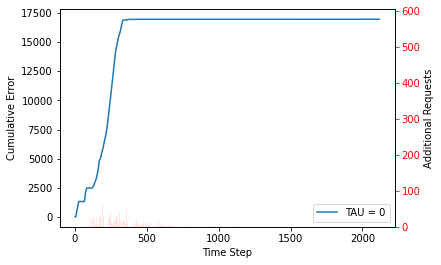

In [28]:
'''
second plot:
cummulative expiration cost vs. time step
label with periods of high traffic and low traffic
do a line per tau
also include a line for the traffic over time
'''
cum_input_len_over_time = [0 for i in x]
for time_step in range(len(_input)):
    if time_step > 0:
        cum_input_len_over_time[time_step] = cum_input_len_over_time[time_step-1]  
    for key in _input[time_step][0].keys():
        cum_input_len_over_time[time_step] += len(_input[time_step][0][key])
print (cum_input_len_over_time)
for i in range(len(_input), len(x)):
    cum_input_len_over_time[i] = cum_input_len_over_time[i-1]

fig,ax1 = plt.subplots()
# print (cost_per_tau_over_time[4])
for tau_num, tau in enumerate(cost_per_tau_over_time):
    ax1.plot(x, tau, label = "TAU = " + str(tau_num))
plt.legend()
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Cumulative Error')
input_len_over_time = [0 for i in x]
for time_step in range(len(_input)):
    for key in _input[time_step][0].keys():
        input_len_over_time[time_step] += len(_input[time_step][0][key])
ax2 = ax1.twinx()
ax2.bar(x, input_len_over_time, color='r', alpha=0.1)
# ax2.plot(x, cum_input_len_over_time, 'r.')
ax2.set_ylabel('Additional Requests')
ax2.tick_params('y',colors='r')
    # plt.savefig('data/Realtime/OpsLimits/cumulative_error_over_time_with_requests' + str(random.randrange(0,100000)) + '.png',dpi=216)    
save_plot(plt, 'cumulative_error_over_time_with_requests')

    # plt.savefig('data/Realtime/cumulative_error_over_time_with_requests' + str(random.randrange(0,100000)) + '.png',dpi=216)

In [29]:
'''
second plot:
traffic over time
'''
input_len_over_time = [0 for i in x]
for time_step in range(len(input)):
    for key in input[time_step][0].keys():
        input_len_over_time[time_step] += len(input[time_step][0][key])
plt.bar(x, input_len_over_time)


TypeError: object of type 'method' has no len()

In [ ]:
'''
timings data
'''
for timings in timing_info:
#     print(timings)
    print(sum(timings))